In [3]:
using JLD2
using FourierFlows
using CairoMakie
using AbstractFFTs
using Printf
using Interpolations
using LsqFit

include("./AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
#run_directory = "/vast/nad9961/mrsw/2091922"
#fourier_directory = "/scratch/nad9961/rsw_fourier/2109555"

#run_directory = "/vast/nad9961/swqg/2126017"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2133652/"

#run_directory = "/vast/nad9961/swqg/2133654"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2141274/"

#run_directory = "/vast/nad9961/swqg/2192791/"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2199948"

#run_directory = "/scratch/nad9961/swqg/2409082/"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2902742/"

#run_directory = "/vast/nad9961/swqg/2903911/"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2910505/"

#run_directory = "/scratch/nad9961/swqg/1003292/"
#fourier_directory = "/scratch/nad9961/swqg_fourier/1041766/"

run_directory = "/scratch/nad9961/2Lqg/1518050/"
fourier_directory = "/scratch/nad9961/2LQG_fourier/1545799"

"/scratch/nad9961/2LQG_fourier/1545799"

In [11]:
Nsnaps = count_key_snapshots(run_directory, "2Lqg")
println(Nsnaps)
t, sol = load_key_snapshot(run_directory, "2Lqg", Nsnaps)
params = read_2Lqg_params(run_directory, "2Lqg")
nx, Lx = get_grid_size(run_directory, "2Lqg")
println("nx = ", nx, "\n")
grid = TwoDGrid(; nx, Lx)

file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 1))
ω_size = size(file["ψt"], 1)
t = file["t"]
T = t[end] - t[1]
dt = t[2] - t[1]
Nω = length(t)
ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
close(file)
f0 = 3.0
Cg = 1.0
qh = 0.5 * (sol[:,:,1] - sol[:,:,2])
ψh = @. -qh / (grid.Krsq + 2*params.F)
uh = @. -1im * grid.l  * ψh
vh = @.  1im * grid.kr * ψh
vxh = 1im * grid.kr .* vh
uyh = 1im * grid.l .* uh
vx = irfft(vxh, grid.nx)
uy = irfft(uyh, grid.nx)
u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
rms_u = sqrt.(sum(u.^2 + v.^2)/grid.nx/grid.ny)
println("rms u: ", rms_u)

eddy_turnover = sqrt.(sum((vx - uy).^2)/grid.nx/grid.ny)
println("eddy turnover: ", eddy_turnover)

3021
nx = 2048

rms u: 0.1384951332971491
eddy turnover: 1.1539310723688128


In [15]:
grid = TwoDGrid(; nx=2048, Lx=2π)
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 1))
ω_size = size(file["ψt"], 1)

Ch = zeros(ω_size, 2 * grid.nkr)
Cω = zeros(ω_size)
for file_idx=1:256
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    k = file["k"]
    t = file["t"]
    Nω = length(t)
    ωs = fftshift(fftfreq(Nω, 1/dt) * 2π)
    q = @. sqrt(k^2 + grid.l[:]^2)
    K_idx = floor.(Int, q) .+ 1
    
    ψt = file["ψt"]
    T = t[end] - t[1]
    dt = t[2] - t[1]
    norm_factor = T / Nω^2 / grid.nx^2 / grid.ny^2 / 2

    println(file_idx)
    result = real.(conj.(ψt) .* ψt) * norm_factor
    @views Ch[:, K_idx] .+= result
    Cω .+= sum(result, dims=2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


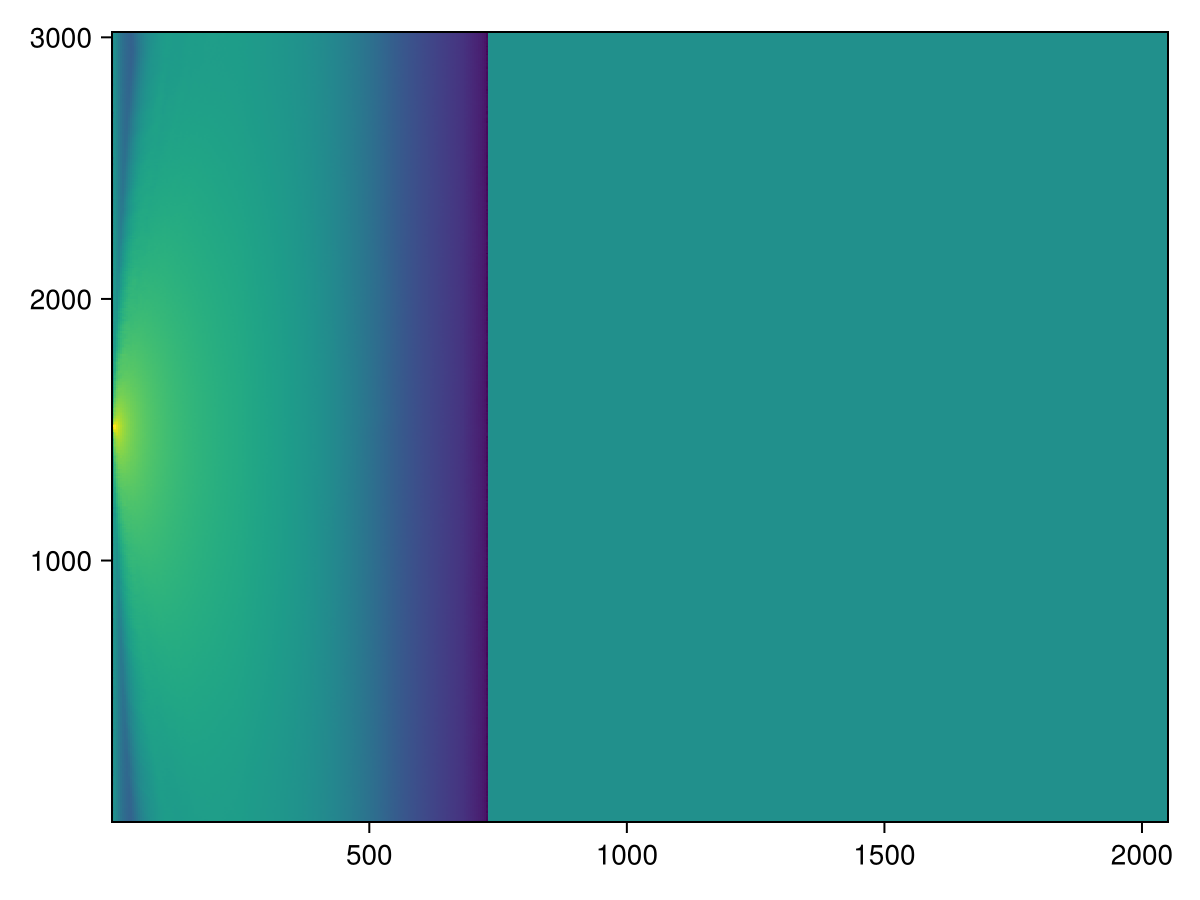

In [16]:
heatmap(Resampler(log.(replace(fftshift(Ch, 1)', 0.0=>NaN))))

0.0


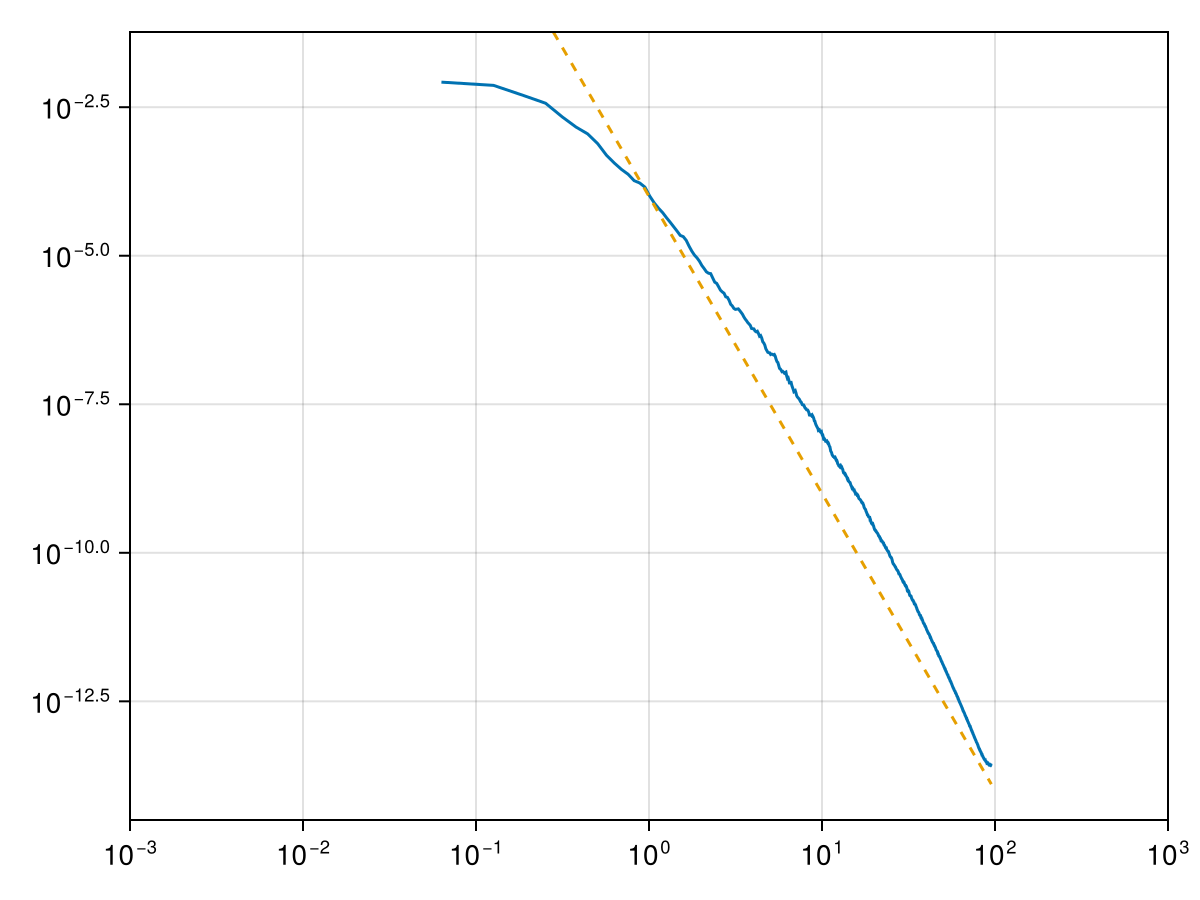

In [36]:
fig = Figure()
Nzero = Int((ω_size)//2+1)
println(ωs[Nzero])
Npos = 1:(Nzero-1)
Nneg = (ω_size):-1:(Nzero)

Cω_tot = Cω[Npos] + Cω[Nneg]
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((1e-3, 1e3), (nothing, nothing)))
ωpos = fftshift(ωs)[Npos]
lines!(ax, ωpos, Cω_tot)
lines!(ax, ωpos, 1e-4*ωpos.^(-5), linestyle=:dash)
#lines!(ax, ωpos, 3e-8*ωpos.^(-5), linestyle=:dash)
#lines!(ax, ωpos, 1e-8*exp.(-2*ωpos), linestyle=:dash)
#lines!(ax, ωpos, 1e-8*ωpos.^(-3))

fig

In [15]:
ωpos

7836-element Vector{Float64}:
  0.0
  0.006276769088387368
  0.012553538176774737
  0.018830307265162105
  0.025107076353549473
  0.03138384544193684
  0.03766061453032421
  0.04393738361871158
  0.05021415270709895
  0.056490921795486315
  0.06276769088387368
  0.06904445997226105
  0.07532122906064842
  ⋮
 49.10944134754247
 49.11571811663086
 49.121994885719246
 49.128271654807634
 49.13454842389602
 49.14082519298441
 49.147101962072796
 49.15337873116118
 49.15965550024957
 49.16593226933796
 49.172209038426345
 49.17848580751473

In [25]:
Npos = 1:(Nzero-1)
Nneg = (ω_size-1):-1:(Nzero)
println(fftshift(ωs)[Nneg][1])
println(fftshift(ωs)[Nneg][end])

println(fftshift(ωs)[Npos][1])
println(fftshift(ωs)[Npos][end])

-0.12624933538488392
-95.31824821558365
0.0
95.2551235478912


In [ ]:
αs = exp.(log(0.01):0.2:log(60.0))
bs = zeros(size(αs))
idx = 1
Kd = 3.0
f0 = 3.0
c = f0 / Kd
println("Fr, b")
for α=αs
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 1))
    t = file["t"]
    dt = t[2] - t[1]
    Nω = length(t)
    ωs = fftshift(fftfreq(Nω, 1/dt) * 2π)
    close(file)
    
    Npoints = 20
    k_max = 100
    k = (1:Npoints)/(Npoints) * k_max
    D_11_p = zeros(Npoints)
    

    ω = @. sqrt(f0^2 + c^2*k^2)
    Cg = @. c^2 * k / ω
    Q = sqrt.(grid.Krsq)

    dq = 0.1
    q = 0.0:dq:grid.kr[end]
    dη = 0.01
    η = (0.0:dη:2π)'
    
    q1 = grid.kr .+ 0 * grid.l
    q2 = 0*grid.kr .+ grid.l

    Ch_demean = Ch[:,:]
    Ch_shifted = fftshift(Ch_demean[:, 1:grid.nkr], 1)
    Ch_itp = extrapolate(scale(interpolate(Ch_shifted, BSpline(Cubic())), ωs, 0:(grid.nkr-1)), 0)
    
    for idx=1:Npoints
        #σ = -Cg[idx] * q1
        σ = -Cg[idx] * q .* cos.(η)
        D_11_p[idx] = α * k[idx]^2 * sum(q.^5 .* cos.(η).^2 .* sin.(η).^2 .* Ch_itp.(σ / α, q) * dq * dη)
        #D_11_p[idx] = k[idx]^2 * sum(q1.^2 .* q2.^2 .* Ch_itp.(σ, Q)) # There should be another factor of α from rescaling ̂C, but it gets cancelled out by renormalizing since the length of time changes
        #D_11_p[idx] = k[idx]^2 * sum(q1.^2 .* q2.^2 .* Chat_Dong.(Q, σ; P, α))
    end
    m(k, p) = p[1]*k.^2# .+ p[2]*k# .+ p[3]
    p0 = [1e-2]
    fit = curve_fit(m, k/Kd, D_11_p, p0)
    println(α * rms_u/c, ": ", fit.param[1] / f0)
    bs[idx] = fit.param[1]
    idx += 1
end

Fr, b
2.438741333960619e-95: 
0.0016915833780089841: 

In [32]:
function spatial_structure(n, Q1, Q2)
    function P(q)
        return q^(-n) * (Q1 < q) * (q < Q2)
    end

    return P
end

function Chat_Dong(q, σ; P, α)
    return P(q) * 2*α/(σ^2 + α^2)
end

Chat_Dong (generic function with 1 method)

In [12]:
P = spatial_structure(5, 1, 176)
Chat_synth = Chat_Dong.(grid.kr, ωs'; P, α=1.0)
heatmap(log.(replace(Chat_synth, 0.0=>NaN)))

ErrorException: Cairo stops rendering images bigger than 32745, which is likely a bug in Cairo. Please resample your image/heatmap with heatmap(Resampler(data)).

In [ ]:
fig = Figure(size=(600, 500), fontsize=20, figure_padding = (10, 30, 5, 5))
ax = Axis(fig[1,1]; xscale=log10, yscale=log10,
    title = "SWQG flow\nψ(x, t) ↦ αψ(x, αt)",
    xlabel="Fr", ylabel=rich("D", subscript("11"),"/k",superscript("2"), "f"),
    limits=((1e-2, 1e1), (1e-10, 1e5)),
    xticks=LogTicks(WilkinsonTicks(4; k_min=3)),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(10),
    xminorgridvisible=true,
    yticks=LogTicks(WilkinsonTicks(7; k_min=5, k_max=11)))
lines!(ax, rms_u*αs/c, bs/f0, color=:blue)
lines!(ax, rms_u*αs/c, bs[30]*(αs/αs[30]).^5 / f0, color=:black, linestyle=:dash)
text!(ax, rms_u*αs[30]/c, 4*bs[30] / f0; text=rich("Fr", superscript("5")))
resize_to_layout!(fig)
#save("images/alpha_b_dependence_swqg_1.eps", fig)
fig

In [ ]:
1+1

In [12]:
α = 1.0
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 1))
t = file["t"]
dt = t[2] - t[1]
Nω = length(t)
ωs = fftshift(fftfreq(Nω, 1/dt) * 2π)
close(file)

Npoints = 200
k_max = 100
k = (1:Npoints)/(Npoints) * k_max
D_11_p = zeros(Npoints)


ω = @. sqrt(f0^2 + c^2*k^2)
Cg = @. c^2 * k / ω
Q = sqrt.(grid.Krsq)
q1 = grid.kr .+ 0 * grid.l
q2 = 0*grid.kr .+ grid.l

Ch_demean = α^2 * Ch[:,:]
Ch_shifted = fftshift(Ch_demean[:, 1:grid.nkr], 1)
Ch_itp = extrapolate(scale(interpolate(Ch_shifted, BSpline(Cubic())), α * ωs, 0:(grid.nkr-1)), 0)

for idx=1:Npoints
    σ = -Cg[idx] * q1
    D_11_p[idx] = k[idx]^2 * sum(q1.^2 .* q2.^2 .* Ch_itp.(σ, Q)) # There should be another factor of α from rescaling ̂C, but it gets cancelled out by renormalizing since the length of time changes
    #D_11_p[idx] = k[idx]^2 * sum(q1.^2 .* q2.^2 .* Chat_Dong.(Q, σ; P, α))
end
m(k, p) = p[1]*k.^2# .+ p[2]*k# .+ p[3]
p0 = [1e-2]
fit = curve_fit(m, k/Kd, D_11_p, p0)
println(α * rms_u/c, ": ", fit.param[1] / f0)

0.0822413572053264: 8.720930970890049e-6


In [37]:
m(k, p) = p[1]*k.^2# .+ p[2]*k# .+ p[3]
p0 = [1e-2]
fit = curve_fit(m, k/Kd, D_11_p, p0)
println(fit.param)
fig = Figure(fontsize=20, size=(500, 500))
ax = Axis(fig[1,1];
    title=@sprintf("Fr = %0.1e", rms_u), ylabel="Radial diffusivity", xlabel=rich("K/K", subscript("D")), 
    xminorticksvisible=true, xminorticks=IntervalsBetween(10), xminorgridvisible=true,
    yminorticksvisible=true, yminorticks=IntervalsBetween(10), yminorgridvisible=true)
#ax2 = Axis(fig[1,2];
#    title=@sprintf("Radial diffusivity\nFr = %0.1e", rms_u), ylabel="Radial diffusivity", xlabel=rich("K/K", subscript("d")))
lines!(ax, k/Kd, D_11_p, label=rich("D", subscript("11"), superscript("p")), color=:blue, linewidth=2)
lines!(ax, k/Kd, m(k/Kd, fit.param), label=rich(@sprintf("%0.2e(K/K", fit.param[1]), subscript("D"), ")", superscript("2")), linestyle=:dash, color=:black)
axislegend(ax, position=:lt)
#lines!(ax2, k/Kd, D_11_p, label=rich("D", subscript("11"), superscript("p")), color=:blue, linewidth=3)
#lines!(ax2, k/Kd, m(k/Kd, fit.param), label=rich(@sprintf("%0.2e(K/K", fit.param[1]), subscript("d"), ")", superscript("2")), linestyle=:dash, color=:black)
#axislegend(ax2, position=:lt)
#α_dict[α] = fit.param[1]
save("images/radial_diffusivity_swqg.eps", fig)
fig

LoadError: UndefVarError: `k` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
ωs

-643.3823846053809:0.031581699617385675:643.3823846053809

In [15]:
σ = -Cg[end] * q1
println(maximum(abs.(σ)))
println(maximum(ωs))
Ch_itp.(σ/10, Q)

255.8848777017259
643.3823846053809


257×512 Matrix{Float64}:
  0.00135023    0.00525539    0.00215267   …   0.00215267    0.00525539
  8.98402e-7    1.67559e-7    3.16244e-7       3.16244e-7    1.67559e-7
  6.04055e-8    5.96276e-8    3.62021e-8       3.62021e-8    5.96276e-8
  4.51878e-8    5.05526e-8    6.49478e-8       6.49478e-8    5.05526e-8
  1.21339e-8    1.20397e-8    1.12946e-8       1.12946e-8    1.20397e-8
  4.13104e-9    4.10292e-9    3.89968e-9   …   3.89968e-9    4.10292e-9
  2.89849e-9    2.96798e-9    3.26902e-9       3.26902e-9    2.96798e-9
  1.615e-9      1.69857e-9    1.92769e-9       1.92769e-9    1.69857e-9
  6.14981e-10   6.27129e-10   6.78061e-10      6.78061e-10   6.27129e-10
  8.01982e-10   8.01729e-10   7.89433e-10      7.89433e-10   8.01729e-10
  5.14675e-10   5.08636e-10   4.86041e-10  …   4.86041e-10   5.08636e-10
  1.06704e-10   1.07488e-10   1.10028e-10      1.10028e-10   1.07488e-10
  4.07218e-10   4.0408e-10    3.92516e-10      3.92516e-10   4.0408e-10
  ⋮                                

In [16]:
f0 = 3
Kd = 3
Npos = Int((length(ωs) + 1)/2) + 2
ωpos = ωs[Npos:end]
Ch_demean = deepcopy(Ch_shifted)


U0_mean = rms_u
factor = U0_mean^2
factor = sum(Ch_demean[Npos:end, 2:end])
P = spatial_structure(6, 0.1, 256)
Chat_synth = Chat_Dong.(grid.kr, ωs'; P, α=eddy_turnover)
cur_factor = sum(Chat_synth'[Npos:end, 2:end])
Chat_synth *= factor / cur_factor
println(sum(Chat_synth))
println(sum(Energy[Npos:end]))


println(size(Ch_demean))
Energy = Ch_demean;

0.0004564345205126935


LoadError: UndefVarError: `Energy` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [17]:
fig = Figure(size=(500, 500), fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel=rich("K/K", subscript("D")), ylabel="ω/f", title=rich("SWQG |ψ(K, ω)|", superscript("2")),
    limits=((grid.kr[2]/Kd, grid.kr[end]/Kd), (ωs[Npos]/f0, ωs[end]/f0)), xticks=LogTicks(WilkinsonTicks(2; k_min=2)))
hm = heatmap!(ax, grid.kr[2:end]/Kd, ωs[Npos:end]/f0, replace(Energy[Npos:end, 2:end]', 0.0=>1e-15), colorscale = log10, colorrange=(1e-15,1e-3))
Colorbar(fig[1,2], hm, ticks=LogTicks(WilkinsonTicks(5; k_min=5)))
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)

save("images/swqg_autocorrelation.png", fig)
fig

LoadError: UndefVarError: `Energy` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
fig = Figure(size=(500, 500), fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel=rich("K/K", subscript("D")), ylabel="ω/f", title=rich("Synthetic |ψ(K, ω)|", superscript("2")),
    limits=((grid.kr[2]/Kd, grid.kr[end]/Kd), (ωs[Npos]/f0, ωs[end]/f0)), xticks=LogTicks(WilkinsonTicks(2; k_min=2)))
hm = heatmap!(ax, grid.kr[2:end]/Kd, ωs[Npos:end]/f0, replace((Chat_synth[2:end, Npos:end]), 0.0=>1e-15), colorscale = log10, colorrange=(1e-15,1e-3))
Colorbar(fig[1,2], hm, ticks=LogTicks(WilkinsonTicks(5; k_min=5)))
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)

save("images/synthetic_autocorrelation.png", fig)
fig

LoadError: SystemError: opening file "/home/nad9961/JuliaRaytracingSW/analysis/Notebooks/images/synthetic_autocorrelation.png": No such file or directory

In [19]:
fig = Figure(size=(800, 600), fontsize=24)
ax2 = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="ω/f", ylabel=rich("|ψ|", superscript("2")),
    limits=((ωs[Npos]/f0, ωs[end]/f0), (1e-20, 1)),
    xticks=LogTicks(WilkinsonTicks(2; k_min=2)),
    xminorticks=IntervalsBetween(10),
    xminorgridvisible=true,
    yminorticks=IntervalsBetween(10),
    yminorgridvisible=true)
lines!(ax2, ωs[Npos:end]/f0, sum(Energy[Npos:end, 2:end], dims=2)[:], color=:blue, label="SWQG Flow")
lines!(ax2, ωs[Npos:end]/f0, sum(Chat_synth'[Npos:end, 2:end], dims=2)[:], color=:red, label="Synthetic Flow")
lines!(ax2, ωs[Npos:end]/f0, 5e-9*(ωs[Npos:end]).^(-5), color=:black, linestyle=:dash)
text!(ax2, ωs[Npos + 1080]/f0, 5e-9*(ωs[Npos + 1080]).^(-5); text=rich("ω", superscript("-5")))
lines!(ax2, ωs[Npos:end]/f0, 1e-5*(ωs[Npos:end]).^(-2), color=:black, linestyle=:dash)
text!(ax2, ωs[Npos + 1080]/f0, 1e-5*(ωs[Npos + 1080]).^(-2); text=rich("ω", superscript("-2")))
colsize!(fig.layout, 1, Aspect(1, 1.0))

ax3 = Axis(fig[1,2]; xscale=log10, yscale=log10, xlabel=rich("K/K", subscript("D")),
    limits=((grid.kr[2]/Kd, grid.kr[end]/Kd), (1e-20, 1)),
    xminorticks=IntervalsBetween(10),
    xminorgridvisible=true,
    yminorticks=IntervalsBetween(10),
    yminorgridvisible=true)
lines!(ax3, grid.kr[2:end]/Kd, replace(sum(Energy[Npos:end, 2:end], dims=1)[:], 0.0=>NaN), color=:blue, label="SWQG Flow")
lines!(ax3, grid.kr[2:end]/Kd, replace(sum(Chat_synth'[Npos:end, 2:end], dims=1)[:], 0.0=>NaN), color=:red, label="Synthetic Flow")
lines!(ax3, grid.kr[2:end]/Kd, 0.1*(grid.kr[2:end]).^(-6), color=:black, linestyle=:dash)
text!(ax3, grid.kr[80]/Kd, 10*(grid.kr[80]).^(-6); text=rich("K", superscript("-6")))
colsize!(fig.layout, 2, Aspect(1, 1.0))
Legend(fig[2,1:2], ax2, orientation=:horizontal)

resize_to_layout!(fig)

save("images/wavenumber_frequency_spectrum.eps", fig)
fig

LoadError: UndefVarError: `Energy` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
fig = Figure(size=(500, 500), fontsize=24)
ax3 = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel=rich("K/K", subscript("D")), ylabel=rich("|ψ(K)|", superscript("2")),
    limits=((grid.kr[2]/Kd, grid.kr[end]/Kd), (1e-20, 1)),
    xminorticks=IntervalsBetween(10),
    xminorgridvisible=true,
    yminorticks=IntervalsBetween(10),
    yminorgridvisible=true)
lines!(ax3, grid.kr[2:end]/Kd, replace(sum(Energy[Npos:end, 2:end], dims=1)[:], 0.0=>NaN), color=:blue, label="SWQG Flow")
lines!(ax3, grid.kr[2:end]/Kd, replace(sum(Chat_synth'[Npos:end, 2:end], dims=1)[:], 0.0=>NaN), color=:red, label="Synthetic Flow")
lines!(ax3, grid.kr[2:end]/Kd, 0.1*(grid.kr[2:end]).^(-6), color=:black, linestyle=:dash)
text!(ax3, grid.kr[80]/Kd, 10*(grid.kr[80]).^(-6); text=rich("K", superscript("-6")))
axislegend(ax3, position=:rt)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)

save("images/wavenumber_spectrum.eps", fig)
fig

LoadError: UndefVarError: `Energy` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
println(sum(sum(Energy[Npos:end, 2:end], dims=1)[:]))
println(sum(sum(Chat_synth'[Npos:end, 2:end], dims=1)[:]))

LoadError: UndefVarError: `Energy` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [22]:
f0 = 3
Kd = 3
Npos = Int((length(ωs))/2) + 2
ωpos = ωs[Npos:end]
Ch_demean = deepcopy(Ch_shifted)
Ch_demean[1,:] .= 0

println(size(Ch_demean))
Energy = Ch_demean

fig = Figure(fontsize=20, size=(500, 500), padding=(10, 30, 10, 10))
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="K/Kd", ylabel="ω/f", title=rich("|ψ(K, ω)|", superscript("2")),
          limits=((grid.kr[2]/Kd, grid.kr[end]/Kd), (ωs[Npos]/f0, ωs[end]/f0)),
            xticks=LogTicks(WilkinsonTicks(2)))
hm = heatmap!(ax, grid.kr[2:end]/Kd, ωs[Npos:end]/f0, replace(Energy[Npos:end, 2:end]', 0.0=>NaN), colorscale = log10, colorrange=(1e-15,1e-3), colormap=:balance)
Colorbar(fig[1,2], hm, ticks=LogTicks(WilkinsonTicks(7; k_min=5)))
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)

#Legend(fig[3, :], ax2, orientation=:horizontal)
save("images/autocorrelation_comparison_a.png", fig)
fig

LoadError: InexactError: Int64(20372.5)

In [36]:
println(size(Chat_synth))
println(size(Energy))

(257, 30182)
(30182, 257)


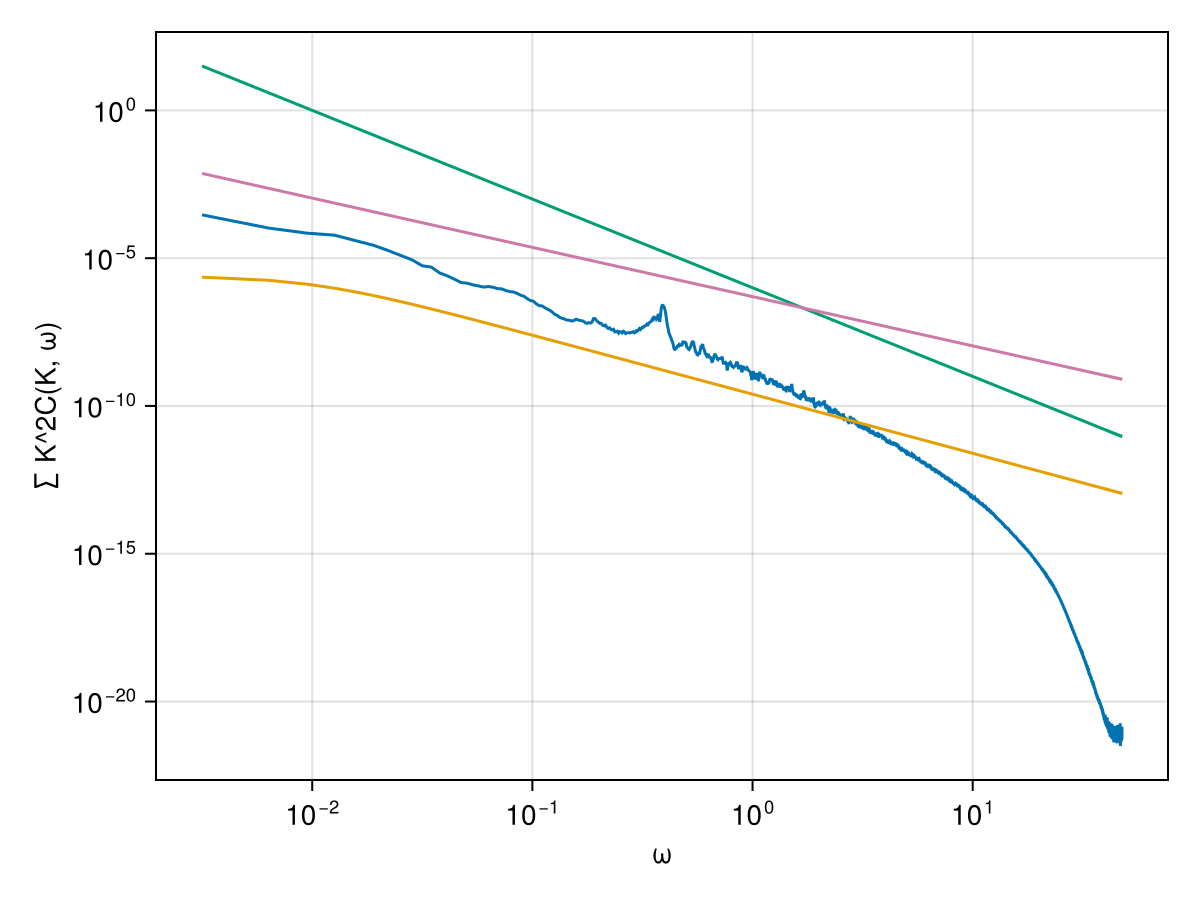

In [13]:
Ch_demean = deepcopy(Ch)
Ch_demean[1,:] .= 0
Ch_shifted = fftshift(Ch_demean[:, 1:grid.nkr], 1)
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="ω", ylabel="∑ K^2C(K, ω)")
value = 2.4e4
α = 2/value
Npos = Int(length(ωs)/2) + 2
ωpos = ωs[Npos:end]
lines!(ax, ωpos, sum((grid.kr.^2)' .* Ch_shifted, dims=2)[Npos:end])
lines!(ax, ωpos, 2.5e-10 ./ (ωpos.^2 .+ 1e-4))
lines!(ax, ωpos, 1e-6*ωpos.^(-3))
lines!(ax, ωpos, 5e-7*ωpos.^(-5/3))

fig

In [210]:
size(ωpos)

(15091,)

In [129]:
fftshift(sum(Ch_shifted, dims=2)[:])

30182-element Vector{Float64}:
 0.00019796855619709362
 8.188648056096729e-5
 3.329450174879411e-5
 1.1729550658253827e-5
 7.945749467398113e-6
 3.4010148636076313e-6
 2.019544827966333e-6
 1.1018116687571943e-6
 7.393766969814707e-7
 4.5067687516762e-7
 3.0505607576330126e-7
 2.842636259639244e-7
 1.643706181935947e-7
 ⋮
 1.7700745126587394e-7
 2.323804743520907e-7
 3.758704160071328e-7
 5.407433643926813e-7
 7.568960431304854e-7
 1.497611569061634e-6
 2.3384273291725294e-6
 3.9097740115664525e-6
 8.289361281953345e-6
 1.0520473348781679e-5
 2.4820404120807195e-5
 8.618326545022087e-5

In [147]:
# Let's assume its sufficiently radial

Npoints = 100
k_max = 100
k = (1:Npoints)/(Npoints) * k_max
D_11_p = zeros(Npoints)
#C_corr = zeros(Nω, 2 * grid.nkr)
#UU_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
#UV_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
#VV_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
#C_corr = zeros(ω_size, grid.nkr, grid.nl)
D_11_p = zeros(Float64, grid.nkr, grid.nl)
D_12 = zeros(Float64, grid.nkr, grid.nl)
D_22 = zeros(Float64, grid.nkr, grid.nl)
f0 = 3.0
c = 1.0
ω = @. sqrt(f0^2 + c^2*grid.Krsq)
Cg_x = @. c * grid.kr / ω
Cg_y = @. c * grid.l / ω
Cg = @. sqrt(Cg_x^2 + Cg_y^2)
Q = sqrt.(grid.Krsq)

α = 1.0
#for file_idx=1:1
file_idx = 1
    #println(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    k = file["k"]
    t = file["t"] / α
    #ugt = α*file["ugt"]
    #vgt = α*file["vgt"]
    q = sqrt.(k^2 + grid.l.^2)
    cos = k * sqrt.(grid.invKrsq)
    sin = grid.l * sqrt.(grid.invKrsq)
    ψt = α * file["ψt"]
    T = t[end] - t[1]
    dt = t[2] - t[1]
    Nω = length(t)
    ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
    
    #Cg_x = grid.kr .* sqrt.(grid.invKrsq)
    #Cg_y = grid.l .* sqrt.(grid.invKrsq)
    σ = @. (-q1 * Cg_x - q2 * Cg_y)
    
    norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
    #V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
    #V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
    #V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
    #@views V_11[ωs .> f0*α, :] .= 0
    #@views V_12[ωs .> f0*α, :] .= 0
    #@views V_22[ωs .> f0*α, :] .= 0
    C_hat = real.(conj.(ψt) .* ψt) * norm_factor
    #K = @. sqrt(l^2 + k^2)
    #K_idx = @. floor(Int, K * refine_factor + 1)
    #@view(UU_corr[:, K_idx]) .+= C_hat
    
    #V_11 = @.  grid.l * grid.l * C_hat
    #V_12 = @. -k * grid.l * C_hat
    #V_22 = @.  k * k * C_hat

    #println(maximum(abs.(ωs)))
    #println(maximum(abs.(σ)))
    Chat_itp = extrapolate.(scale.(interpolate.(eachslice(fftshift(C_hat, 1), dims=2), Ref(BSpline(Linear()))), Ref(ωs)), 0)

    coefficient = @. grid.Krsq * (q1^2 + q2^2) - (grid.kr * q1 + grid.l * q2)^2
    Chats = [chat_itp.(σ) for chat_itp in Chat_itp]
    println(size(Chats))
    term = coefficient .* Chat_itp.(σ)
    D_11 += sum(q1 .* q1 * term, dims=3)[:,:,1]
    #D_11 += k      .* k      .* v11_itp.(σ, grid.l)
    #D_12 += k      .* grid.l .* v12_itp.(σ, grid.l)
    #D_22 += grid.l .* grid.l .* v22_itp.(σ, grid.l)

    #println(itp.(σ, grid.l))
    #K = @. sqrt(grid.l[:]^2 + k^2)
    #K_idx = @. floor(Int, K * refine_factor + 1)
    
    #@view(UU_corr[:, K_idx]) .+= real.(conj.(ugt) .* ugt)
    #@view(UV_corr[:, K_idx]) .+= real.(conj.(ugt) .* vgt)
    #@view(VV_corr[:, K_idx]) .+= real.(conj.(vgt) .* vgt)
    println(file_idx)
    close(file)
#end

LoadError: MethodError: no method matching +(::Float64, ::Matrix{Float64})
For element-wise addition, use broadcasting with dot syntax: scalar .+ array
The function `+` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:596[24m[39m
[0m  +([91m::ChainRulesCore.NotImplemented[39m, ::Any)
[0m[90m   @[39m [35mChainRulesCore[39m [90m/ext3/pkgs/packages/ChainRulesCore/Vsbj9/src/[39m[90m[4mtangent_arithmetic.jl:24[24m[39m
[0m  +(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [35mChainRulesCore[39m [90m/ext3/pkgs/packages/ChainRulesCore/Vsbj9/src/[39m[90m[4mtangent_arithmetic.jl:25[24m[39m
[0m  ...


In [226]:
Nω

32597

In [45]:
map(Chat_itp, 4)

LoadError: MethodError: objects of type Vector{Interpolations.FilledExtrapolation{Float64, 1, ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, Vector{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Int64}} are not callable
Use square brackets [] for indexing an Array.
The object of type `Vector{Interpolations.FilledExtrapolation{Float64, 1, ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, Vector{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Int64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

In [48]:
D_11_true = grid.kr .* grid.kr/(2π)^2 .* D_11
D_12_true = grid.kr .* grid.l /(2π)^2 .* D_12
D_22_true = grid.l  .* grid.l /(2π)^2 .* D_22
D_11_p = @. (grid.kr^2 .* D_11_true + 2 * grid.kr * grid.l * D_12_true + grid.l^2 * D_22_true) * grid.invKrsq

257×512 Matrix{Float64}:
 0.0  2.97395e-7   7.41461e-8    2.19744e-7   …  8.05282e-8    1.79298e-7
 0.0  6.46235e-27  3.22102e-11   3.83926e-13     3.66565e-11  -3.23117e-27
 0.0  2.54083e-13  0.0           1.78772e-14     0.0           4.21797e-13
 0.0  2.23135e-12  3.98068e-12  -1.75302e-31     4.71038e-12   1.14754e-12
 0.0  1.13218e-11  3.32428e-14   2.83978e-15     1.48995e-13   1.93561e-12
 0.0  1.60086e-11  6.94311e-14   8.17336e-12  …  7.82833e-14   2.04418e-12
 0.0  1.35965e-11  8.32301e-13   4.75209e-12     3.90374e-13   3.71533e-12
 0.0  1.13936e-11  1.63519e-12   2.33682e-13     7.29046e-13   5.73067e-12
 0.0  1.28602e-11  2.60009e-12   7.77526e-13     1.59922e-12   7.00069e-12
 0.0  1.54457e-11  2.47583e-12   1.57603e-12     3.8951e-12    8.52396e-12
 0.0  1.89084e-11  2.94554e-12   5.30737e-13  …  7.04388e-12   1.05259e-11
 0.0  2.33059e-11  6.9042e-12    2.29537e-13     1.07192e-11   1.29451e-11
 0.0  2.86661e-11  2.39374e-11   6.03291e-13     6.47087e-12   1.57925e-11
 

[1.0437469905163092e-13, 0.0, 0.0]


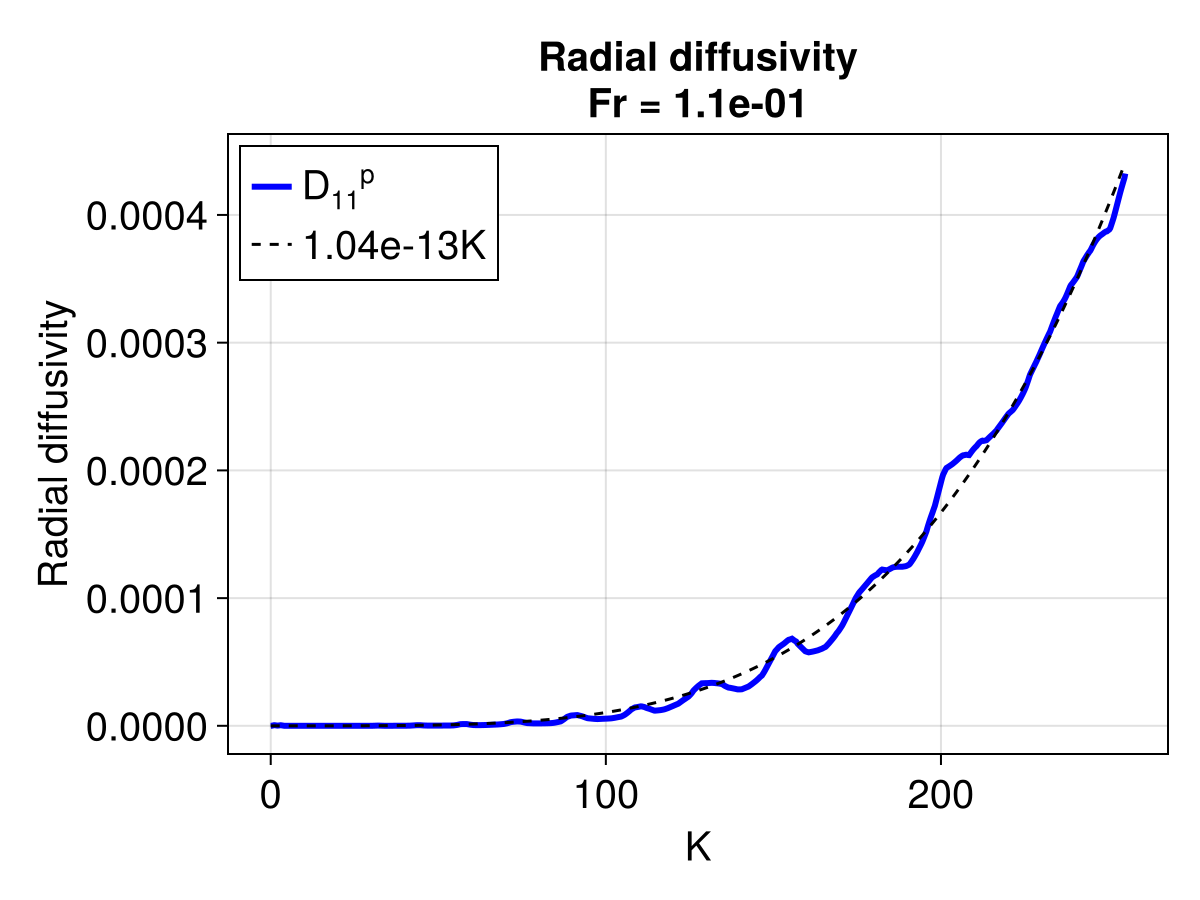

In [52]:
using LsqFit
ρ, D_11_p_R = FourierFlows.radialspectrum(D_11_p, grid)
m(k, p) = p[1]*k.^4# .+ p[2]*k# .+ p[3]
p0 = [1e-8, 0, 0]
fit = curve_fit(m, ρ, D_11_p_R[:], p0)
println(fit.param)
fig = Figure(fontsize=20)
ax = Axis(fig[1,1]; title=@sprintf("Radial diffusivity\nFr = %0.1e", α * 1.1e-1), ylabel="Radial diffusivity", xlabel="K")
lines!(ax, ρ, D_11_p_R[:], label=rich("D", subscript("11"), superscript("p")), color=:blue, linewidth=3)
lines!(ax, ρ, m(ρ, fit.param), label=rich(@sprintf("%0.2eK", fit.param[1])), linestyle=:dash, color=:black)
axislegend(ax, position=:lt)
save("radial_diffusivity.eps", fig)
fig

In [51]:
D_11_p_R

1024×1 Matrix{Float64}:
 0.0
 5.203688197196006e-8
 1.7861564753285078e-7
 3.354384761501911e-7
 4.78207547291498e-7
 4.4991629431019643e-7
 3.548580421187146e-7
 2.638416029906673e-7
 1.767590951404605e-7
 2.2333734166398767e-7
 3.014470155470124e-7
 3.7933709894958515e-7
 4.5717163409290025e-7
 ⋮
 0.0004051028023264415
 0.0004076219422181768
 0.0004101554494527113
 0.0004127001301352579
 0.0004152075926148645
 0.00041767855180375286
 0.00042004974056234715
 0.00042231182632473604
 0.0004245847067876525
 0.000426821425074873
 0.00042899366873224825
 0.00043238997476473934

In [78]:
D_11 = 0
D_12 = 0
D_22 = 0

f0 = 0.0
c = 1.0
ω = @. sqrt(f0^2 + c^2*grid.Krsq)

k_idx = 10
l_idx = 10
K = grid.kr[k_idx]
L = grid.l[l_idx]

Cg_x = (@. c * grid.kr * sqrt(grid.invKrsq))[k_idx,l_idx] #/ ω
Cg_y = (@. c * grid.l * sqrt(grid.invKrsq))[k_idx,l_idx] #/ ω


for file_idx=1:176
    #println(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    k = file["k"]
    t = file["t"] / α
    ψt = α * file["ψt"]
    T = t[end] - t[1]
    dt = t[2] - t[1]
    Nω = length(t)
    ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
    
    σ = @. (-k * Cg_x - grid.l * Cg_y)
    
    norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
    C_hat = real.(conj.(ψt) .* ψt) * norm_factor
    
    V_11 = @.  grid.l * grid.l * C_hat
    V_12 = @. -k * grid.l * C_hat
    V_22 = @.  k * k * C_hat
    
    v11_itp = extrapolate(scale(interpolate(fftshift(V_11), BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v12_itp = extrapolate(scale(interpolate(fftshift(V_12), BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v22_itp = extrapolate(scale(interpolate(fftshift(V_22), BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    
    D_11 += sum(k      .* k      .* v11_itp.(σ, grid.l))
    D_12 += sum(k      .* grid.l .* v12_itp.(σ, grid.l))
    D_22 += sum(grid.l .* grid.l .* v22_itp.(σ, grid.l))
    println(file_idx)
end
#D_11_true = grid.kr .* grid.kr/(2π)^2 .* D_11
#D_12_true = grid.kr .* grid.l /(2π)^2 .* D_12
#D_22_true = grid.l  .* grid.l /(2π)^2 .* D_22
#D_11_p = @. (grid.kr^2 .* D_11_true + 2 * grid.kr * grid.l * D_12_true + grid.l^2 * D_22_true) * grid.invKrsq

close(file)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


In [80]:
grid.kr[14]^2 * D_11

306.0017992352485

In [32]:
sum(V_11, dims=1)

1×512 Matrix{Float64}:
 0.0  0.0678352  0.17189  0.180644  …  0.180644  0.17189  0.0678352

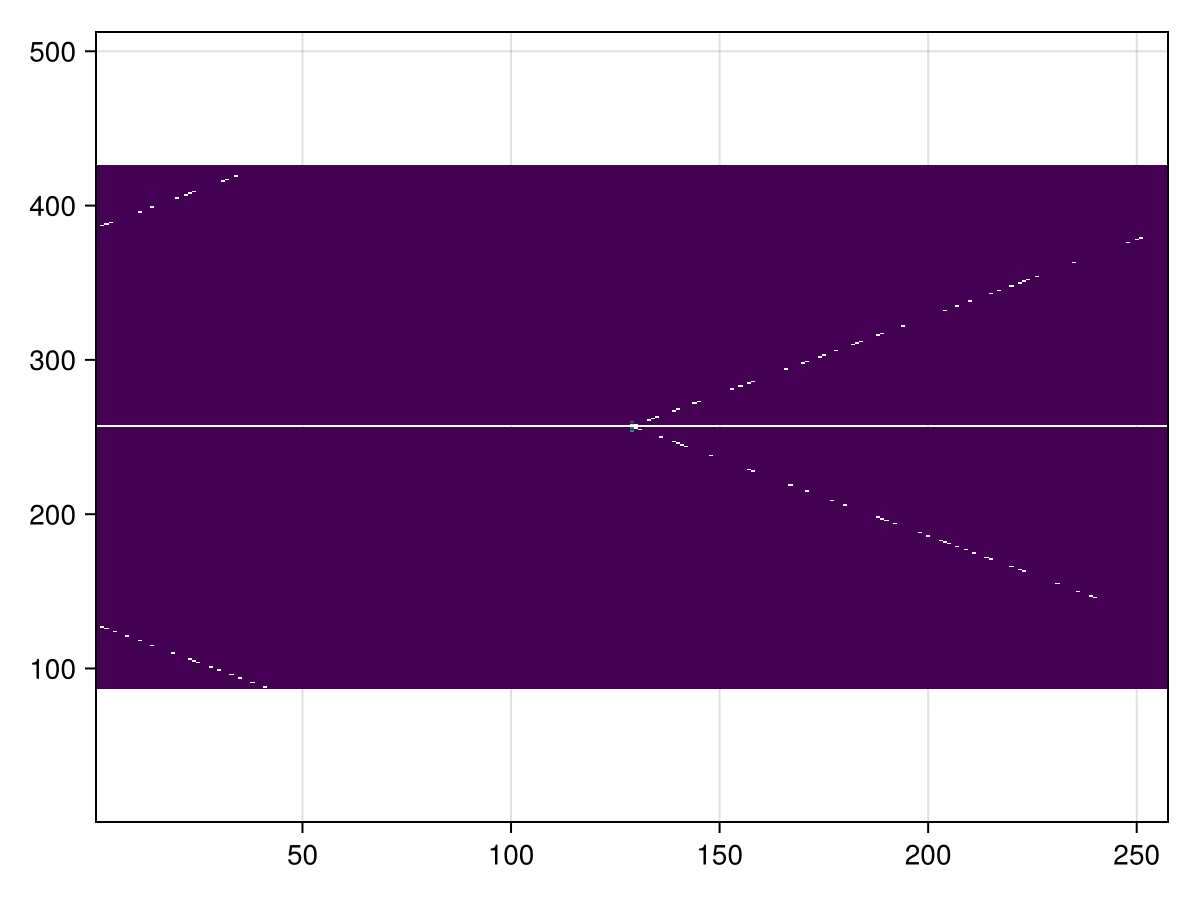

In [46]:
#heatmap(ωs[1:100:end], fftshift(grid.l[:]), log.(replace(abs.(fftshift(C_hat))[1:100:end,:], 0.0=>NaN)))
heatmap(fftshift((replace(abs.(D_11_p), 0.0=>NaN))))

In [9]:
Lx = 2π
Ly = 4π
Nx = 57
Ny = 32
x = (0:(Nx-1))/Nx * Lx
y = (0:(Ny-1))/Ny * Ly
dx = Lx/Nx
dy = Ly/Ny
test_signal = sin.(x .+ y')
th = rfft(test_signal)
Nkr = mod(Nx, 2) == 0 ? Int(Nx/2) : Int((Nx-1)/2)
println(sum(abs2.(test_signal) * dx * dy))

sum_val = sum(abs2, th[1,:])
sum_val += 2 * sum(abs2, th[2:Nkr-1,:])
sum_val += sum(abs2, th[Nkr, :])
println(sum_val * Lx/Nx^2 * Ly/Ny^2)

39.478417604357446
39.47841760435743


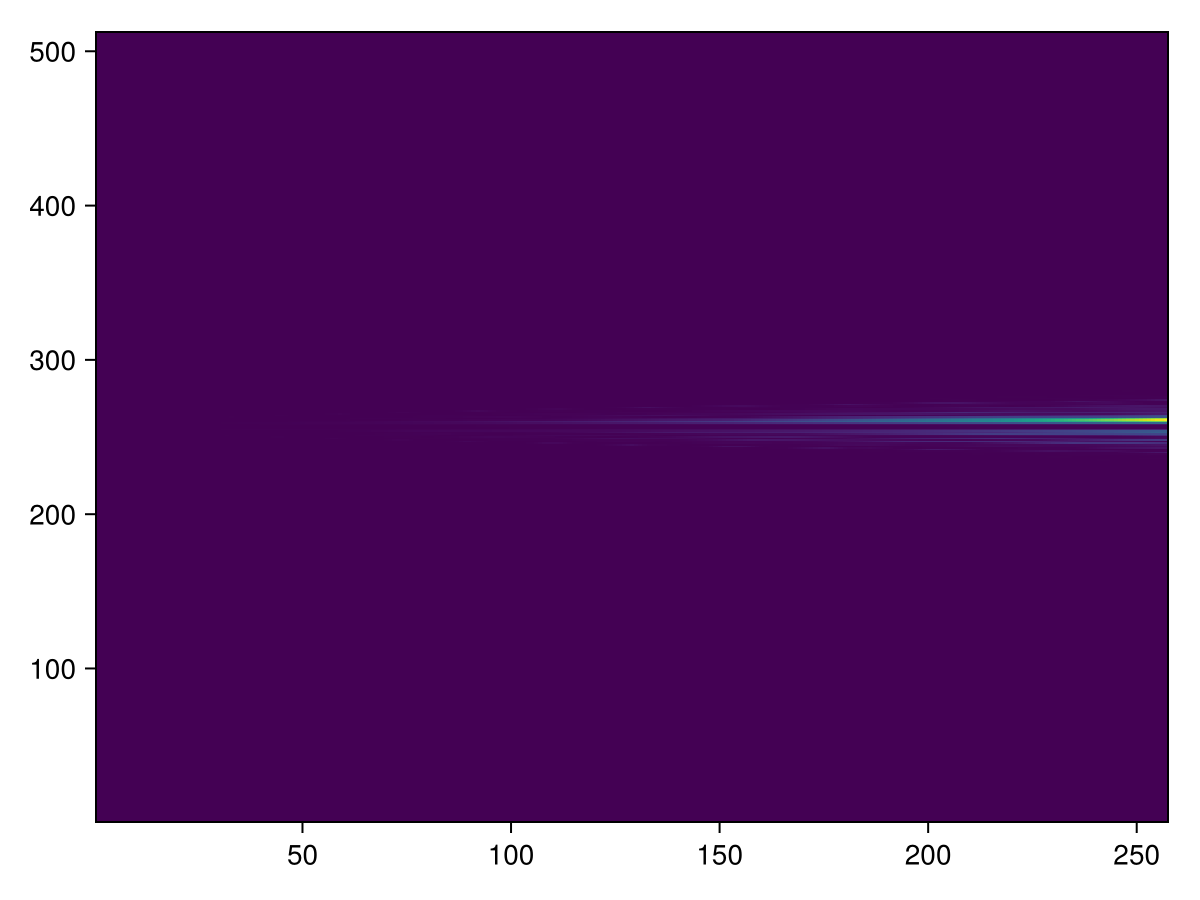

In [10]:
D_11 = 0
D_12 = 0
D_13 = 0

heatmap(fftshift(abs.(D_11_p), 2))

In [11]:
A = zeros(3, 3)
idx = [2, 2, 1]
vec = [1., 1., 1.]
@view(A[:, idx]) .+= vec
A

3×3 Matrix{Float64}:
 1.0  2.0  0.0
 1.0  2.0  0.0
 1.0  2.0  0.0

In [12]:
UV_corr

4529×514 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0im  0.

In [13]:
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 4, 16))
k = file["k"]
K = @. sqrt(grid.l[:]^2 + k^2)
K_idx = @. floor(Int, K * refine_factor + 1)
ugt = file["ugt"]
vgt = file["vgt"]

LoadError: KeyError: key "ugt" not found

In [14]:
conj.(vgt) .* ugt

LoadError: UndefVarError: `vgt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
for α = [1.0]#, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    f0 = 3.0
    c = 1.0
    ω = @. sqrt(f0^2 + c^2*grid.Krsq)
    Cg_x = @. c * grid.kr / ω
    Cg_y = @. c * grid.l / ω
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 2))
    k = file["k"]
    t = file["t"]/α
    ugt = α*file["ugt"]
    vgt = α*file["vgt"]
    T = (t[end] - t[1])
    dt = (t[2] - t[1])
    Nω = length(t)
    ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
    σ = @. -k * Cg_x - grid.l * Cg_y
    
    norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
    V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
    V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
    V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
    @views V_11[ωs .> f0, :] .= 0
    @views V_12[ωs .> f0, :] .= 0
    @views V_22[ωs .> f0, :] .= 0
    
    v11_itp = extrapolate(scale(interpolate(V_11, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v12_itp = extrapolate(scale(interpolate(V_12, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v22_itp = extrapolate(scale(interpolate(V_22, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    
    D_11 = k      .* k      .* v11_itp.(σ, grid.l)
    D_12 += k      .* grid.l .* v12_itp.(σ, grid.l)
    D_22 += grid.l .* grid.l .* v22_itp.(σ, grid.l)
    D_11_true = grid.kr .* grid.kr/(2π)^2 .* D_11
    D_12_true = grid.kr .* grid.l /(2π)^2 .* D_12
    D_22_true = grid.l  .* grid.l /(2π)^2 .* D_22
    D_11_p = @. (grid.kr^2 .* D_11_true + 2 * grid.kr * grid.l * D_12_true + grid.l^2 * D_22_true) * grid.invKrsq
    ρ, D_11_r = FourierFlows.radialspectrum(D_11_p, grid)
    m(k, p) = p[1]*k.^2
    p0 = [2e-8]
    fit = curve_fit(m, ρ, D_11_r[:], p0)
    println(@sprintf("α: %0.2e\tb: %0.2e", α, fit.param[1]))
end

LoadError: KeyError: key "ugt" not found

In [16]:
lines(ρ, D_11_r[:])

LoadError: UndefVarError: `D_11_r` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [17]:
α = 1.0
ugt = α*file["ugt"]
vgt = α*file["vgt"]
real.(conj.(ugt) .* vgt)[45, 46]

LoadError: KeyError: key "ugt" not found

In [18]:
Nsnaps = 1024
α = 2.0
dt = 0.1 / α

t = ((0:(Nsnaps-1))*dt) / α
y = α * sin.(5 * t)
yh = fft(y)

println(sum(abs2.(y)) * dt)
println(sum(abs2.(yh)) * dt / Nsnaps)

102.74560982058978
102.74560982058986


In [19]:
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 40, 160))
k = file["k"]
t = file["t"]
#ugt = α*file["ugt"]
#vgt = α*file["vgt"]
ψt = file["ψt"]
T = t[end] - t[1]
dt = t[2] - t[1]
Nω = length(t)
ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
σ = @. -k * Cg_x - grid.l * Cg_y

norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
#V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
#V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
#V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
#@views V_11[ωs .> f0*α, :] .= 0
#@views V_12[ωs .> f0*α, :] .= 0
#@views V_22[ωs .> f0*α, :] .= 0
C_hat = fftshift(real.(conj.(ψt) .* ψt)) * norm_factor

32597×512 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

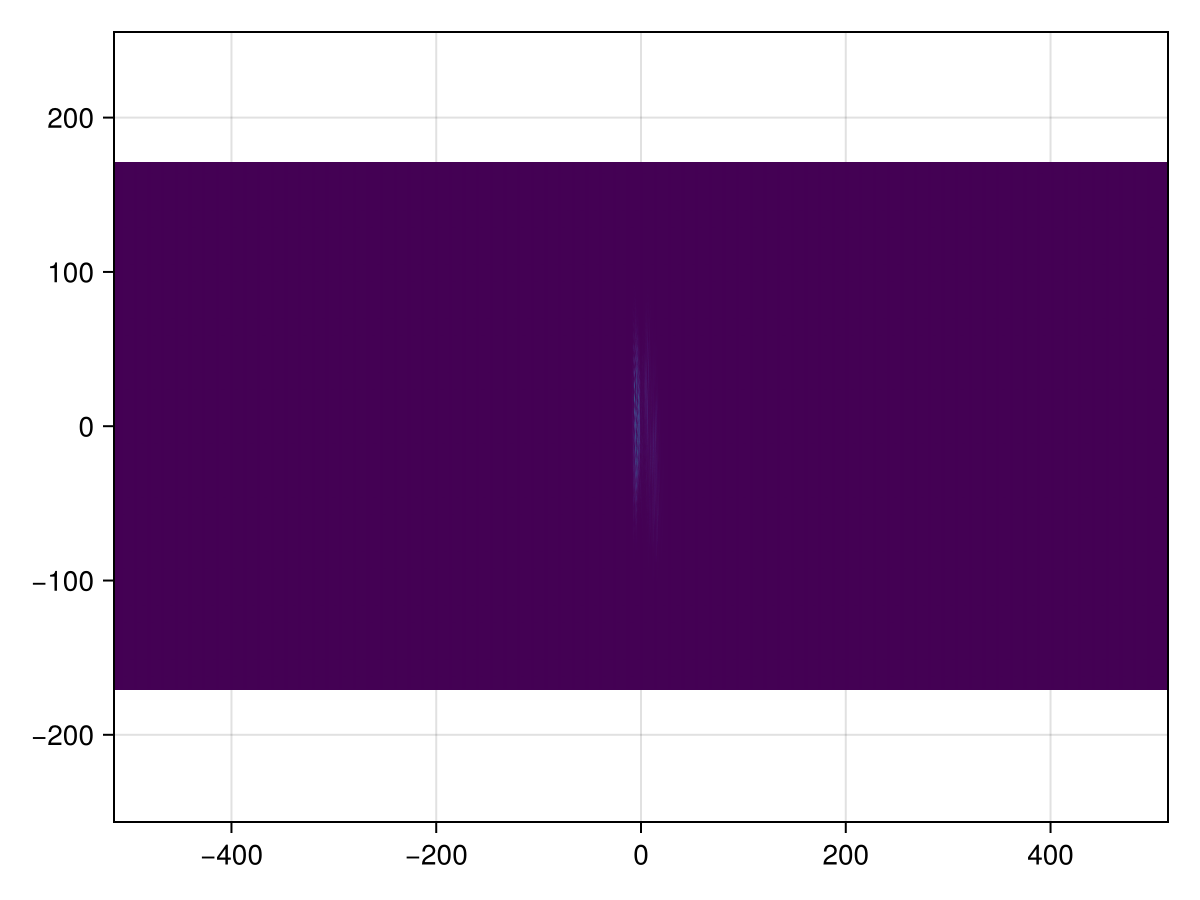

In [20]:
heatmap(ωs, fftshift(grid.l[:]), (replace(C_hat, 0.0=>NaN)))

In [21]:
C_hat

32597×512 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [22]:
grid = OneDGrid(; nx=256, Lx=2π)
Nt = 1024
T = 10π
dt = T/Nt
t = (0:(Nt-1)) * dt


0.0:0.030679615757712823:31.38524692014022

In [87]:
run_directory = "/vast/nad9961/swqg/2192791/"
Nsnaps = count_key_snapshots(run_directory, "qgsw")
println(Nsnaps)
t, sol = load_key_snapshot(run_directory, "qgsw", Nsnaps)
params = read_swqg_params(run_directory, "qgsw")

f0 = 3.0
Cg = 1.0
qh = sol
ψh = @. -qh / (grid.Krsq + params.Kd2)
uh = @. -1im * grid.l  * ψh
vh = @.  1im * grid.kr * ψh
u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
q = irfft(qh, grid.nx)
sqrt.(sum(u.^2 + v.^2)/grid.nx/grid.ny)
close(file)

32598


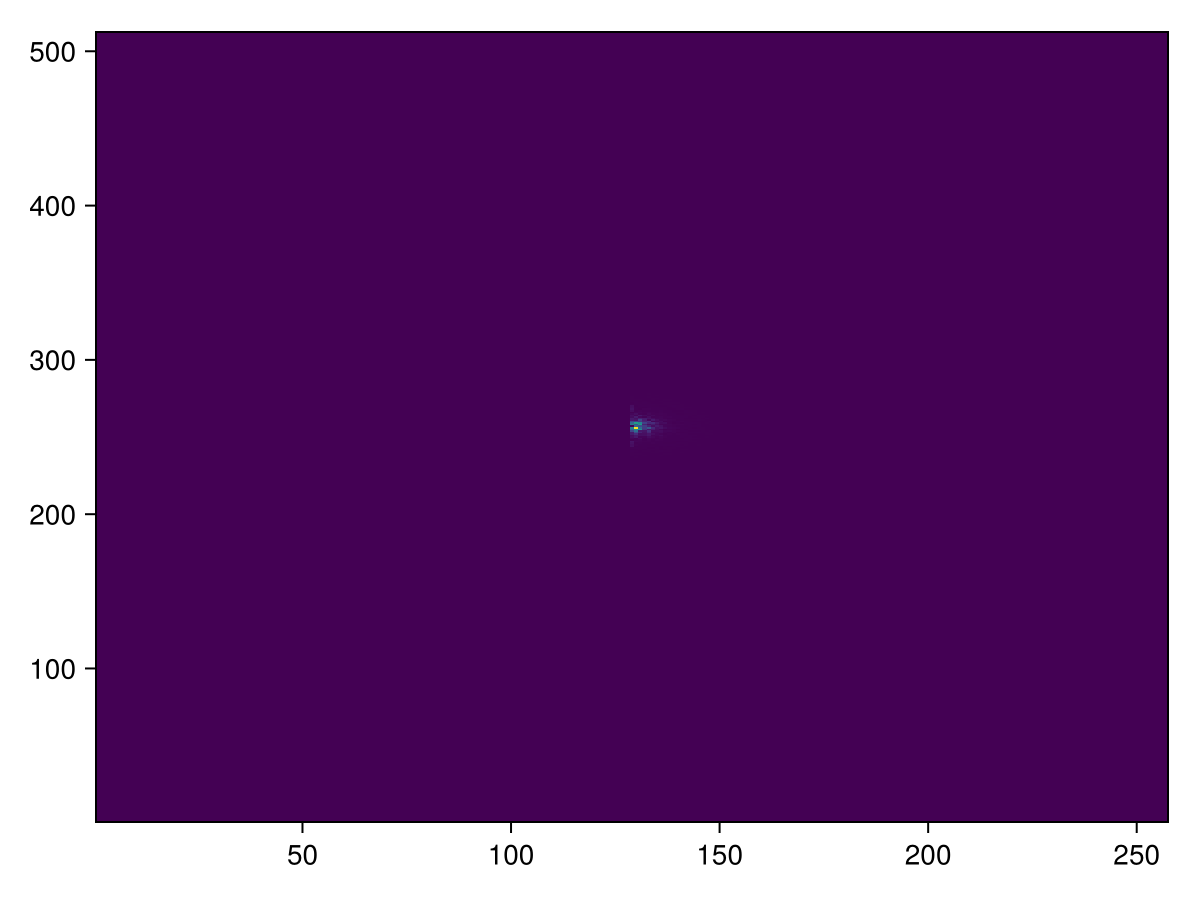

In [91]:
heatmap(fftshift(log.(replace(abs.(ψh))))

In [25]:
grid2 = TwoDGrid(nx=38, Lx=2π)
sum(grid2.k.^2 .+ 0*grid2.l)

174002.0

In [26]:
cos = grid2.k .* grid2.invKsq
q = grid2.Ksq
sum((q .* cos).^2)

174002.0

In [262]:
grid = OneDGrid(;Lx=4π, nx=512)

y = sin.(grid.x)
println(1 / grid.Lx * sum(y.^2) * grid.dx)

yh = fft(y)
println(1/grid.nx^2 * sum(abs2.(yh)))

0.49999999999999994
0.5
